# Neural Network : Part-2  Building 2- Layer Image Classifier 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import imageio
from datetime import datetime


plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)

## 2-layer neural network - Outline

- Initialize the parameters for a two-layer network and for an $2$-layer neural network.
- Forward propagation .
     - [LINEAR->ACTIVATION] forward propagation step (resulting in $Z^{[l]}$) using ACTIVATION function (relu/sigmoid).
     - Stack the [LINEAR->RELU] forward function and  [LINEAR->SIGMOID].
- Compute the loss.
- Implement the backward propagation module.
    - Complete the [LINEAR->ACTIVATION] backward function using gradient of the ACTIVATE function relu_backward /sigmoid_backward).
    - Stack [LINEAR->RELU] backward and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

## Initialization

Functions that will initialize the parameters for your model. The first function will be used to initialize parameters for a two layer model. The second one will generalize this initialization process to $L$ layers.

###  Initialization for 2-layer Neural Network 
- Where model's structure is: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 

In [2]:
def initialize_parameters(inputLayerSize, hiddenLayerSize, outputLayerSize):
 
    np.random.seed(1)
    W1 = np.random.randn(hiddenLayerSize, inputLayerSize) * 0.01
    b1 = np.zeros((hiddenLayerSize, 1))
    W2 = np.random.randn(outputLayerSize, hiddenLayerSize) * 0.01
    b2 = np.zeros((outputLayerSize, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

## Forward propagation
   Model is [LINEAR -> RELU]  -> LINEAR -> SIGMOID 
   
- LINEAR Farward
The linear forward computes $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$ where $A^{[0]} = X$$
- ACTIVATION Forward where ACTIVATION will be either ReLU or Sigmoid. 
- "[LINEAR->ACTIVATION]" forward : Group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION) because in deep learning, the linear forward step and activation step is counted as a single layer in the neural network, not two layers.

$$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$$
 where the activation "g" can be **sigmoid** or **relu**.

### Linear Forward 

In [3]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b) 
    return Z, cache

### Activation Forward

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \displaystyle \frac{1}{ 1 + e^{-(W A + b)}}$. 

In [4]:
def sigmoid(Z):   
    A = 1/(1+np.exp(-Z))
    cache = Z  
    return A, cache

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. 

In [5]:
def relu(Z):    
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

### Linear Activation Forward 

In [6]:
def linear_activation_forward(A_prev, W, b, activation): # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

## Cost/Loss function
 Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$


In [7]:
def compute_cost(AL, Y):   
    m = Y.shape[1]
    cost = (-1/m) * np.sum( np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T) )
    cost = np.squeeze(cost)
    return cost

## Backward propagation
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] -> LINEAR -> SIGMOID backward (whole model)
- Update Parameters

In [8]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)
  
    return dA_prev, dW, db

### Activation backward
- **`sigmoid_backward`**

In [9]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

- **`relu_backward`**

In [10]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0 # When z <= 0, you should set dz to 0 as well.   
    return dZ

### Linear-Activation backward

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$. 
```python
dZ = sigmoid_backward(dA, activation_cache)
```
```python
dZ = relu_backward(dA, activation_cache)
```

In [11]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)       
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  
    return dA_prev, dW, db

### Update Parameters
Update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [12]:
def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * grads["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * grads["db2"]    
    return parameters

## Architecture of Model

### 2-Layer Neural Network
The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. 

<u>Detailed Architecture of Model</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

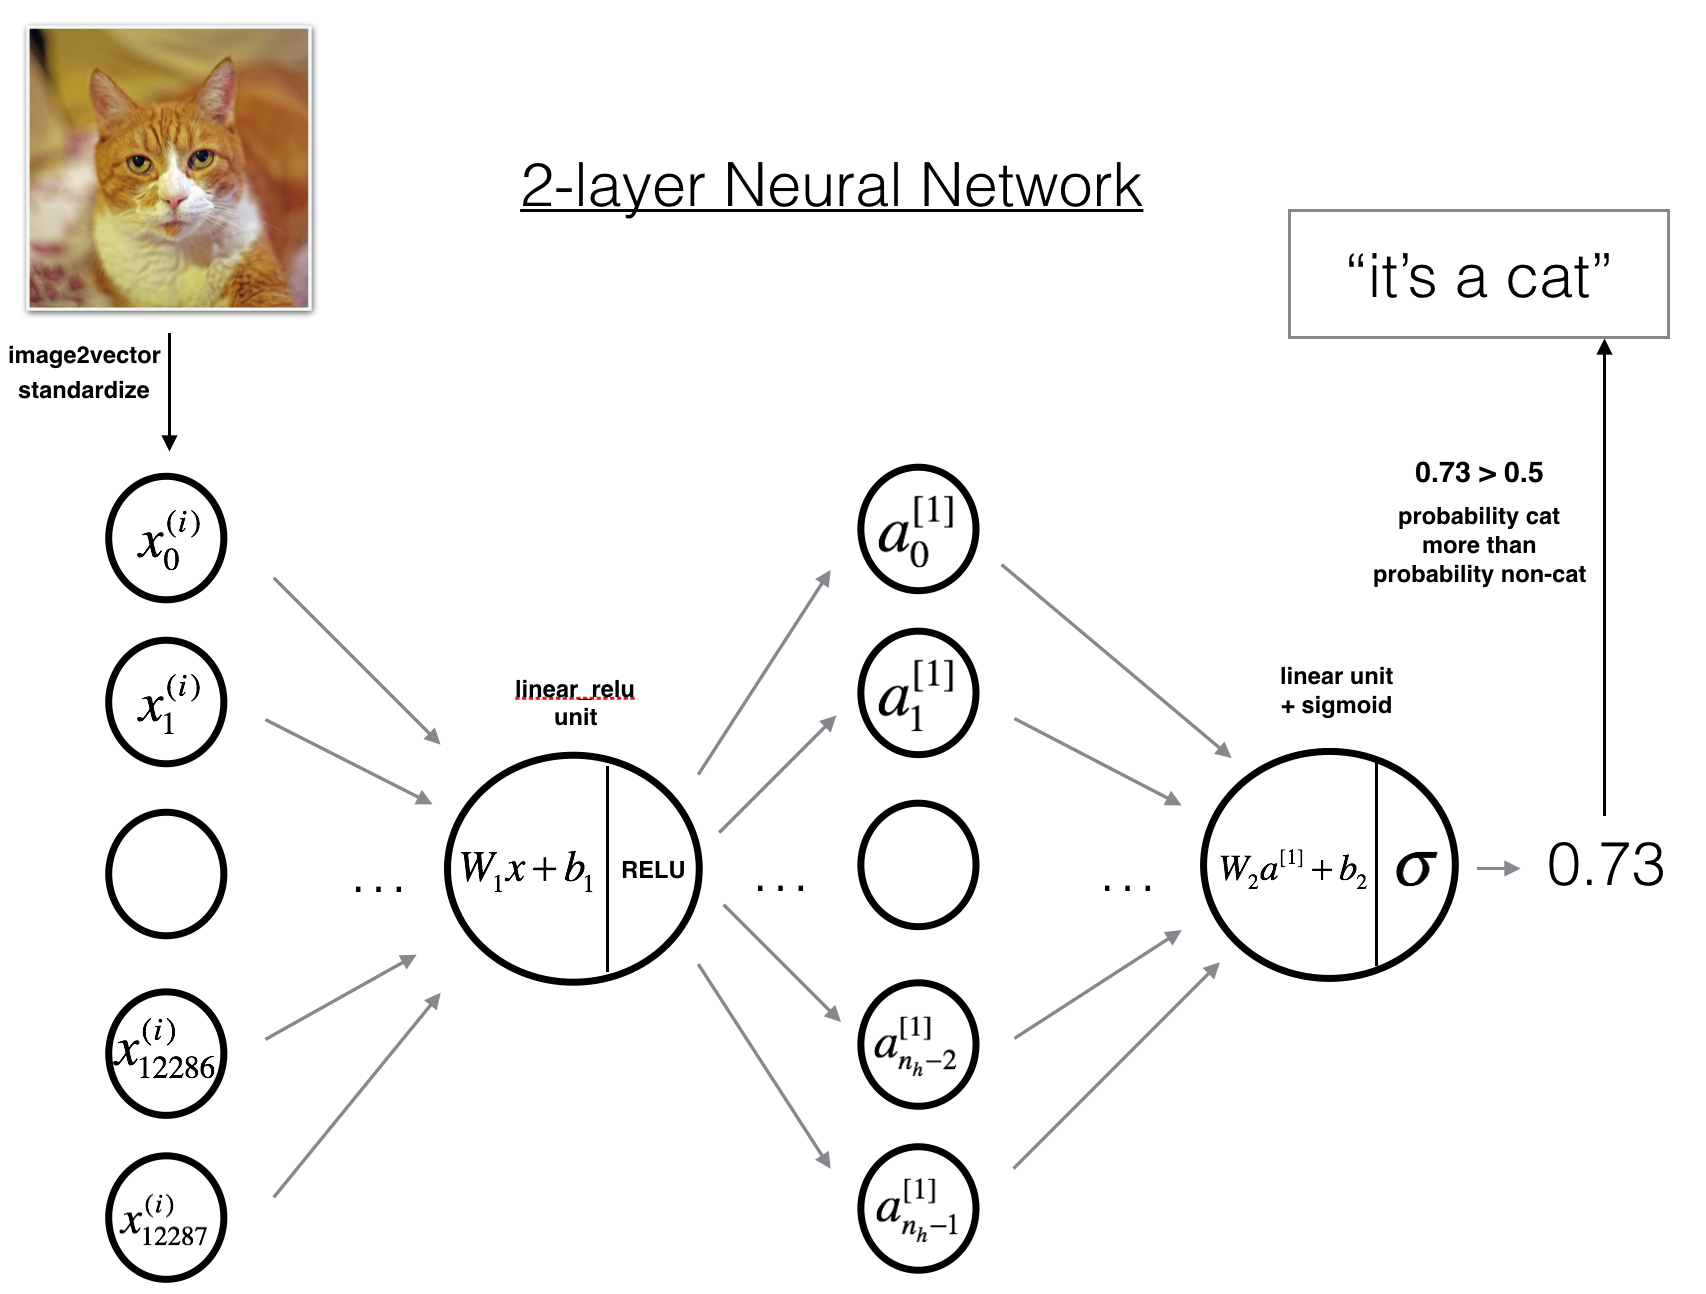

In [13]:
def model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
        
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (inputLayerSize, hiddenLayerSize, outputLayerSize) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(inputLayerSize, hiddenLayerSize, outputLayerSize)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
         
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    parameters["costs"]=costs
    parameters["learning_rate"]=learning_rate
    
       

    
    return parameters

# Prediction

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [14]:
def predict(X, myModel):
    m = X.shape[1]
    parameters = dict(myModel)
    del parameters["costs"]
    del parameters["learning_rate"]
   
    nLayers = len(parameters) // 2 # number of layers in the neural network
    yhat = np.zeros((1,m))
        
        
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    caches = []
    # Forward Propagation to calculate A2 (probabilities)
   
    A1, cache= linear_activation_forward(X, W1, b1, activation = "relu")
   
    A2, cache = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
    
    
    probas = A2  # myModel contains parameters including cost and learning rate
        
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            yhat[0,i] = 1
        else:
            yhat[0,i] = 0
            
    return yhat

# ---------------------------------------------

# Using Model

# ---------------------------------------------

## Load Dataset ##

A dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [15]:
def load_dataset():
    train_dataset = h5py.File('../Input/Cat_VS_NonCatDS/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../Input/Cat_VS_NonCatDS/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [16]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


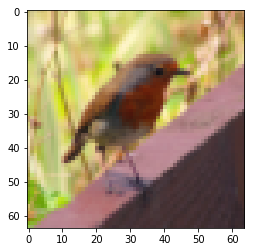

In [17]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

### Transform Data

reshape and standardize the images before feeding them to the network. 

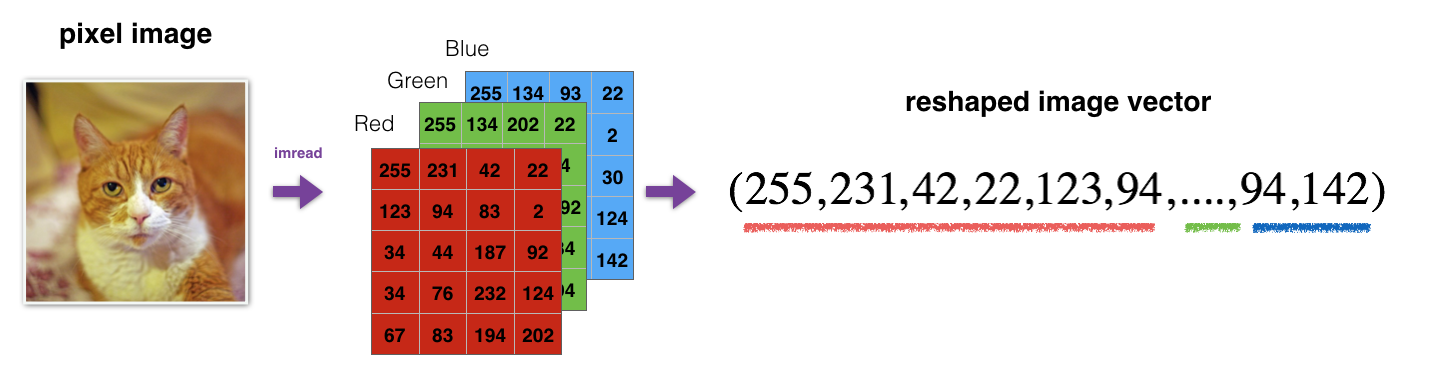

A trick  to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [18]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# Train Model

In [19]:
inputLayerSize = len(train_set_x_flatten)     # num_px * num_px * 3
hiddenLayerSize = 7
outputLayerSize = 1
layers_dims = (inputLayerSize, hiddenLayerSize, outputLayerSize)
myModel = model(train_set_x, train_set_y, layers_dims = layers_dims, num_iterations = 2500, print_cost=True)

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203888
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614827
Cost after iteration 1400: 0.19850735037466105
Cost after iteration 1500: 0.17448318112556663
Cost after iteration 1600: 0.17080762978096709
Cost after iteration 1700: 0.11306524562164712
Cost after iteration 1800: 0.09629426845937145
Cost after iteration 1900: 0.08342617959726858
Cost after iteration 2000: 0.07439078704319076
Cost after iteration 2100: 0.06630748

## Plot Learning Curve

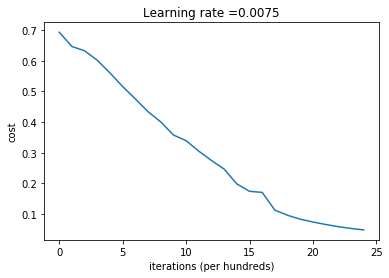

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(myModel['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(myModel["learning_rate"]))
plt.show()

# Accuracy

In [21]:
# Predict test/train set examples (≈ 2 lines of code)
Y_prediction_test = predict(test_set_x, myModel)
Y_prediction_train = predict(train_set_x,  myModel)


# Print train/test Errors
print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - train_set_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - test_set_y)) * 100))

train accuracy: 100.0 %
test accuracy: 72.0 %


# Results Analysis
Find images the model labeled incorrectly.

In [22]:
def print_mislabeled_images(classes, test_set_x, test_set_y, Y_prediction_test):
    a = Y_prediction_test + test_set_y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_set_x[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(Y_prediction_test[0,index])].decode("utf-8") 
                  + " \n Class: " + classes[test_set_y[0,index]].decode("utf-8"))

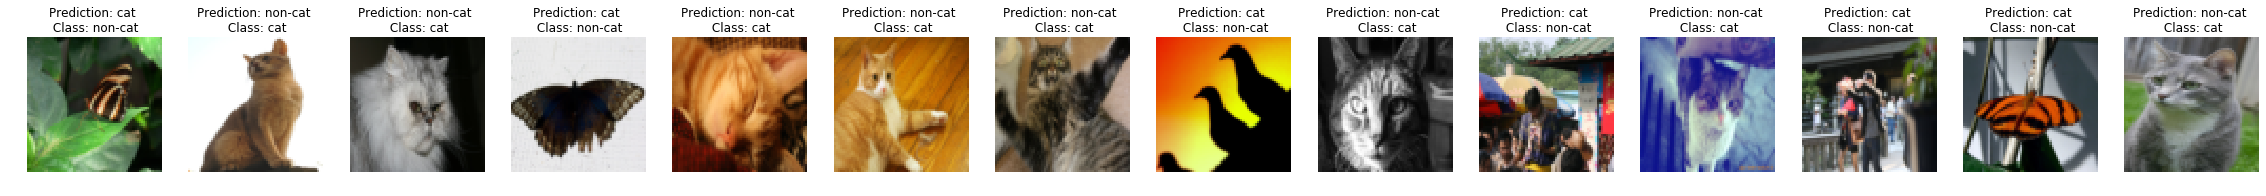

In [23]:
print_mislabeled_images(classes, test_set_x, test_set_y, Y_prediction_test)